In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from hottbox.core import Tensor, TensorTKD
from hottbox.algorithms.decomposition import HOSVD, HOOI
from hottbox.utils.generation import residual_tensor
from coursework.data import get_image, plot_tensors

In [3]:
np.random.seed(0)

[Return to Table of Contents](./0_Table_of_contents.ipynb)

# Tucker Decomposition

<img src="./imgs/TensorTKD.png" alt="Drawing" style="width: 500px;"/>

In previous [assignment](./2_Efficient_representation_of_multidimensional_arrays.ipynb), you have been provided materials which cover efficient representations of mutlidimensional arrays of data, such as the Tucker form. In this module, you will take a closer look at it and the assiciated computational methods.


Any tensor of arbitrarily large order can be decomposed in the Tucker form. As illustrated above, a tensor $\mathbf{\underline{X}} \in \mathbb{R}^{I \times J \times K}$ can be represented as a dense core tensor $\mathbf{\underline{G}}$ and a set of factor matrices $\mathbf{A} \in \mathbb{R}^{I \times Q}, \mathbf{B} \in \mathbb{R}^{J \times R}$ and $\mathbf{C} \in
\mathbb{R}^{K \times P}$

$$
\mathbf{\underline{X}} = \mathbf{\underline{G}} \times_1 \mathbf{A} \times_2 \mathbf{B} \times_3 \mathbf{C} = \Big[    \mathbf{\underline{G}} ;  \mathbf{A},  \mathbf{B}, \mathbf{C}      \Big]
$$


On practice, there exist several computational methods to accomplish this all of which are combined into a Tucker Decomposition framework. The two most commonly used algorithms are:
1. Higher Order Singular Value Decomposition ([HOSVD](#Higher-Order-Singular-Value-Decomposition-(HOSVD)))
1. Higher Order Orthogonal Iteration ([HOOI](#Higher-Order-Orthogonal-Iteration-(HOOI)))


# Higher Order Singular Value Decomposition (HOSVD)

The HOSVD is a special case of the Tucker decomposition, in which all the factor matrices are constrained to be orthogonal. They are computed as truncated version of the left singular matrices of all possible mode-$n$ unfoldings of tensor $\mathbf{\underline{X}}$:

$$
\begin{aligned}
\mathbf{X}_{(1)} &= \mathbf{U}_1  \mathbf{\Sigma}_1 \mathbf{V}_1^T \quad \rightarrow \quad \mathbf{A} = \mathbf{U}_1[1:R_1]\\
\mathbf{X}_{(2)} &= \mathbf{U}_2  \mathbf{\Sigma}_2 \mathbf{V}_2^T \quad \rightarrow \quad \mathbf{B} = \mathbf{U}_2[1:R_2] \\
\mathbf{X}_{(3)} &= \mathbf{U}_3  \mathbf{\Sigma}_3 \mathbf{V}_3^T \quad \rightarrow \quad \mathbf{C} = \mathbf{U}_3[1:R_3] \\
\end{aligned}
$$

After factor matrices are obtained, the core tensor $\mathbf{\underline{G}}$ is computed as

$$
\mathbf{\underline{G}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^T \times_2 \mathbf{B}^T \times_3 \mathbf{C}^T        
$$


# Higher Order Orthogonal Iteration (HOOI)

HOOI algorithm is another special case of the Tuker decomposition. Like HOSVD, it decomposes a tensor into a dense core tensor and orthogonal factor matrices. The difference between the two lies in the fact that in HOOI the factor matrices are optimized iteratively using an Alternating Least Squares (ALS) approach. In other words, the tucker representation $[ \mathbf{\underline{G}};\mathbf{A}^{(1)}, \mathbf{A}^{(2)}, \cdots,\mathbf{A}^{(N)} ]$ of the given tensor $\mathbf{\underline{X}}$ is obtained through the HOOI as follows

$$
\begin{aligned}
&\mathbf{\underline{Y}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^{(1)T} \times_2 \cdots \times_{n-1} \mathbf{A}^{(n-1)T} \times_{n+1} \mathbf{A}^{(n+1)} \times \cdots \times_N \mathbf{A}^{(N)} \\
&\mathbf{A}^{(n)} \leftarrow R_n \text{ leftmost singular vectors of } \mathbf{Y}_{(n)}
\end{aligned}
$$

The above is repeated until convergence, then the core tensor $\mathbf{\underline{G}} \in \mathbb{R}^{R_1 \times R_2 \times \cdots \times R_N}$ is computed as

$$
\mathbf{\underline{G}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^{(1)T}  \times_2 \mathbf{A}^{(2)T} \times_3 \cdots  \times_N \mathbf{A}^{(N)T}
$$

# Multi-linear rank

The **multi-linear rank** of a tensor $\mathbf{\underline{X}} \in \mathbb{R}^{I_1 \times \cdots \times I_N}$ is the $N$-tuple $(R_1, \dots, R_N)$ where each $R_n$ is the rank of the subspace spanned by mode-$n$ fibers, i.e. $R_n = \text{rank} \big( \mathbf{X}_{(n)} \big)$. Thus, for our order-$3$ tensor the multi-linear rank is $(R_1, R_2, R_3)$. Multi-linear rank provides flexibility in compression and approximation of the original tensor.

> **NOTE:** For a tensor of order $N$ the values $R_1, R_2, \dots , R_N$ are not necessarily the same, whereas, for matrices (tensors of order 2) the equality $R_1 = R_2$ always holds, where $R_1$ and $R_2$ are the matrix column rank and row rank respectively.



# Performing tensor decomposition

In [4]:
# Create tensor
I, J, K = 5, 6, 7
array_3d = np.random.rand(I * J * K).reshape((I, J, K)).astype(np.float)
tensor = Tensor(array_3d)

# Initialise algorithm
algorithm = HOSVD()

# Perform decomposing for selected multi-linear rank
ml_rank = (4, 5, 6)
tensor_tkd = algorithm.decompose(tensor, ml_rank)

# Result preview
print(tensor_tkd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_tkd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_tkd.core)

Tucker representation of a tensor with multi-linear rank=(4, 5, 6).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (5, 6, 7) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (5, 4)
Mode-1 factor matrix is of shape (6, 5)
Mode-2 factor matrix is of shape (7, 6)

	Core tensor
This tensor is of order 3 and consists of 120 elements.
Sizes and names of its modes are (4, 5, 6) and ['mode-0', 'mode-1', 'mode-2'] respectively.


C:\Users\Nima\AppData\Local\Temp\ipykernel_21280\863141707.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  array_3d = np.random.rand(I * J * K).reshape((I, J, K)).astype(np.float)


# Evaluation and reconstruction

Tucker representation of an original tensor is almost always an approximation, regardless of which algorithm has been employed for performing decomposition. Thus, relative error of approximation is commonly used in order to evaluate performance of computational methods, i.e. the ratio between a Frobenious norms of residual and original tensors.

In [5]:
# Compute residual tensor
tensor_res = residual_tensor(tensor, tensor_tkd)

# Compute error of approximation
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))

Relative error of approximation = 0.21320264561618074


## **Assigment 1**

1. Create a tensor of order 4 with sizes of each mode being defined by prime numbers and  obtain a Tucker representation using HOOI algorithm with multi-linear (4, 10, 6, 2). Then calculation ratio between the number of elements in the original tensor and its Tucker form.

1. For a tensor that consists of 1331 elements, which multi-linear rank guarantees a perfect reconstruction from its Tucker form and why. Is such choice reasonable for practical applications?


### Solution: Part 1

In [6]:
# Create a tensor
I, J, K, L = 5, 3, 2, 7
array_4d = np.random.rand(I * J * K * L).reshape((I, J, K, L)).astype(np.float)
tensor = Tensor(array_4d)

C:\Users\Nima\AppData\Local\Temp\ipykernel_21280\1775712982.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  array_4d = np.random.rand(I * J * K * L).reshape((I, J, K, L)).astype(np.float)


In [7]:
# Perform decomposition
algorithm = HOOI()

# Perform decomposing for selected multi-linear rank
ml_rank = (4, 10, 6, 2)
tensor_tkd = algorithm.decompose(tensor, ml_rank)
# Result preview
print(tensor_tkd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_tkd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_tkd.core)

Tucker representation of a tensor with multi-linear rank=(4, 3, 2, 2).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2', 'mode-3']
With corresponding latent components described by (5, 3, 2, 7) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (5, 4)
Mode-1 factor matrix is of shape (3, 3)
Mode-2 factor matrix is of shape (2, 2)
Mode-3 factor matrix is of shape (7, 2)

	Core tensor
This tensor is of order 4 and consists of 48 elements.
Sizes and names of its modes are (4, 3, 2, 2) and ['mode-0', 'mode-1', 'mode-2', 'mode-3'] respectively.


In [8]:
# Print ratio
tensor_res = residual_tensor(tensor, tensor_tkd)

# Compute error of approximation
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))

Relative error of approximation = 0.3915596219269979


### Solution: Part 2

# Application: Image compression 

Color images can be naturally represented as a tensor of order three with the shape `(height x width x channels)` where channels are, for example, Red, Blue and Green (RGB)

<img src="./imgs/image_to_base_colors.png" alt="Drawing" style="width: 500px;"/>

By keeping its original structure, allows to apply methods from multi-linear analysis. For instance, we can employ algorithms for Tucker decompositions in order to commress oringinal informaiton by varying values of desired multi-linear rank.

```python
# Get data in form of a Tensor
car = get_image(item="car", view="top")
tensor = Tensor(car)

# Initialise algorithm and preform decomposition
algorithm = HOSVD()
tensor_tkd = algorithm.decompose(tensor, rank=(25, 25, 3))

# Evaluate result
tensor_res = residual_tensor(tensor, tensor_tkd)
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))
```

When can also visually inspect image obtained by reconstructing the Tucker representation
```python
# Reconstruction
tensor_rec = tensor_tkd.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(tensor, tensor_rec)
```

<img src="./imgs/car_orig_vs_reconstructed_25_25_3.png" alt="Drawing" style="width: 500px;"/>

## **Assigment 2**
For this assignment you are provided with function `get_image()` which requires two parameters: `item` and `view`. The valid values for former are **car** and **apple**, while the latter takes only **side** and **top**. 

1. Use multi-linear rank equal to `(50, 50, 2)` in order to obtain Tucker representations of images of the car and apple. Analyse results by visually inspecting their reconstructions.

1. Use multi-linear rank equal to `(50, 50, 2)` in order to obtain Tucker representations of images of the apple taken from the top and from the side. Analyse results by visually inspecting their reconstructions.

1. What would happen to the reconstruction if the value of multi-linear rank corresponding to the channel mode is decreased to 1.


### Solution: Part 1

In [9]:
# Create tensors from images
car = get_image(item="car", view="side")
car_tensor = Tensor(car)

apple = get_image(item="apple", view="side")
apple_tensor = Tensor(apple)

In [10]:
# Perform decomposition
algorithm = HOSVD()
car_tensor_tkd = algorithm.decompose(car_tensor, rank=(50, 50, 2))
apple_tensor_tkd = algorithm.decompose(apple_tensor, rank=(50, 50, 2))

Relative error of approximation = 0.040336257582103234
Relative error of approximation = 0.06574690406026351


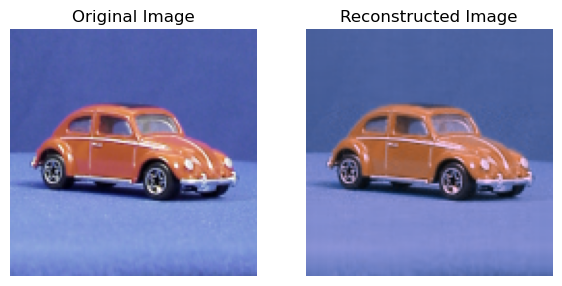

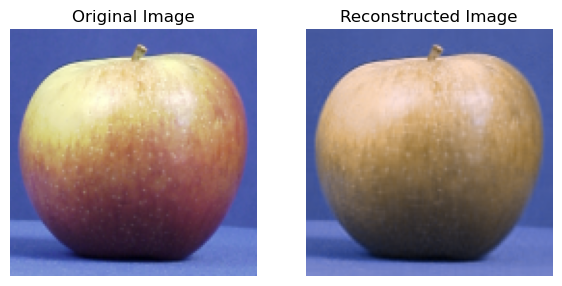

In [11]:
# Evaluate results
car_tensor_res = residual_tensor(car_tensor, car_tensor_tkd)
car_rel_error = car_tensor_res.frob_norm / car_tensor.frob_norm

apple_tensor_res = residual_tensor(apple_tensor, apple_tensor_tkd)
apple_rel_error = apple_tensor_res.frob_norm / apple_tensor.frob_norm

print("Relative error of approximation = {}".format(car_rel_error))
print("Relative error of approximation = {}".format(apple_rel_error))

# Reconstruction
car_tensor_rec = car_tensor_tkd.reconstruct()
apple_tensor_rec = apple_tensor_tkd.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(car_tensor, car_tensor_rec)
plot_tensors(apple_tensor, apple_tensor_rec)

By reducing the rank from 3 to 2 in the multi-linear rank representation of the core tensor, only two degrees of freedom are available to represent color information. The Tucker decomposition chooses the most significant color representations for each image, and discard one of channel of colour information, in this sense, information is lost with regards to colour, and this means that the reconstructed image will not be able to capture the true colour of the original image, which can be seen above. Since the image of the car is largely composed of red and blue colours, and very little, if any green, it means that reducing the number of channels that represent colour leaves the resulting reconstructed image largely unaffected in terms of colour. The apple which contains colours from all three colour channels, thus when the colour information is reduced to only 2 channels in Tucker decomposition, it means that information regarding its true colour is lost, which can be seen in the images above. On the other hand, the reduction of the image to 50x50 in the Tucker decomposition, means that the car, which has more details is more discernibly affected by the blurring effects of compression.


### Solution: Part 2

In [12]:
# Create tensors from images
side_apple = get_image(item="apple", view="side")
side_apple_tensor = Tensor(side_apple)

top_apple = get_image(item="apple", view="top")
top_apple_tensor = Tensor(top_apple)

In [13]:
# Perform decomposition
algorithm = HOSVD()
side_tensor_tkd = algorithm.decompose(side_apple_tensor, rank=(50, 50, 2))
top_tensor_tkd = algorithm.decompose(top_apple_tensor, rank=(50, 50, 2))

Relative error of approximation (Side) = 0.06574690406026347
Relative error of approximation (Top) = 0.037062258387408294


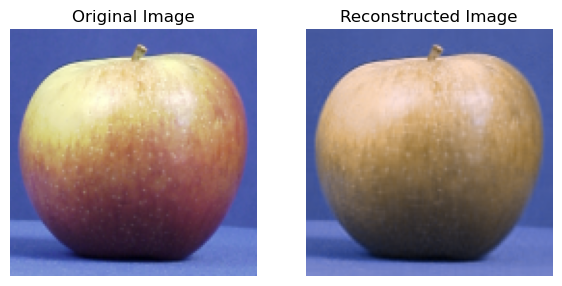

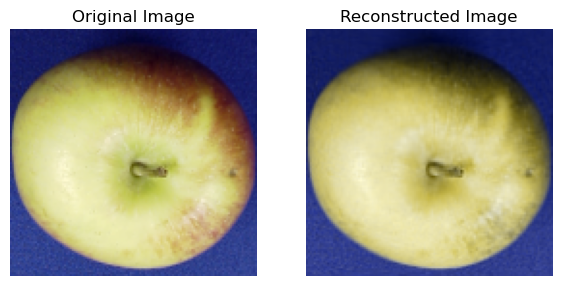

In [14]:
# Evaluate results
side_tensor_res = residual_tensor(side_apple_tensor, side_tensor_tkd)
side_rel_error = side_tensor_res.frob_norm / side_apple_tensor.frob_norm

top_tensor_res = residual_tensor(top_apple_tensor, top_tensor_tkd)
top_rel_error = top_tensor_res.frob_norm / top_apple_tensor.frob_norm

print("Relative error of approximation (Side) = {}".format(side_rel_error))
print("Relative error of approximation (Top) = {}".format(top_rel_error))

# Reconstruction
side_tensor_rec = side_tensor_tkd.reconstruct()
top_tensor_rec = top_tensor_tkd.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(side_apple_tensor, side_tensor_rec)
plot_tensors(top_apple_tensor, top_tensor_rec)

Comparing the apple's side and top images, the red color dominates the side image while the top image has more green coverage. By reducing the rank from 3 to 2 in the multi-linear rank representation of the core tensor, only two degrees of freedom are available to represent color information. The Tucker decomposition chooses the most significant color representations for each image, and discard one of channel of colour information, in this sense, information is lost with regards to colour, and this means that the reconstructed image will not be able to capture the true colour of the original image, which can be seen above. In the side view, the least prevalent color, green, is attenuated, leaving the apple with a brown-red hue, while in the top view, the red streaks are replaced with darker green and brown hues. The reduction in ranks from 128 to 50 leads to a decrease in image resolution and softens the apple-background boundary. The relative error in approximation is significantly higher in the side profile than the top due to the side profile changing to brown, whereas the original green hue mostly remains in the top view after Tucker decomposition.

### Solution: Part 3

In [15]:
# Create tensors from images
top_car = get_image(item="car", view="top")
top_car_tensor = Tensor(top_car)

top_apple = get_image(item="apple", view="top")
top_apple_tensor = Tensor(top_apple)

In [16]:
# Perform decomposition
algorithm = HOSVD()
top_tensor_car_tkd = algorithm.decompose(top_car_tensor, rank=(50, 50, 1))
top_tensor_apple_tkd = algorithm.decompose(top_apple_tensor, rank=(50, 50, 1))

Relative error of approximation (Car) = 0.2544471822623988
Relative error of approximation (Apple) = 0.037062258387408294


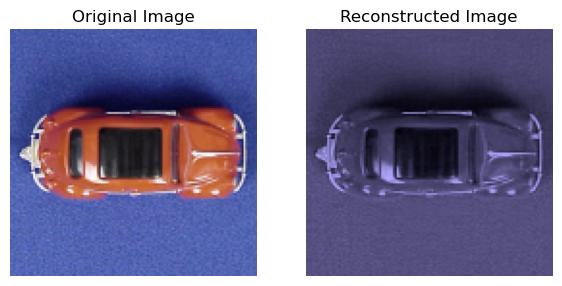

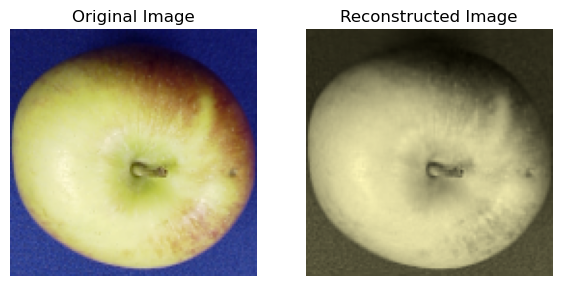

In [17]:
# Evaluate results
top_car_tensor_res = residual_tensor(top_car_tensor, top_tensor_car_tkd)
top_car_rel_error = top_car_tensor_res.frob_norm / top_car_tensor.frob_norm

top_apple_tensor_res = residual_tensor(top_apple_tensor, top_tensor_apple_tkd)
top_apple_rel_error = top_tensor_res.frob_norm / top_apple_tensor.frob_norm

print("Relative error of approximation (Car) = {}".format(top_car_rel_error))
print("Relative error of approximation (Apple) = {}".format(top_apple_rel_error))

# Reconstruction
top_car_tensor_rec = top_tensor_car_tkd.reconstruct()
top_apple_tensor_rec = top_tensor_apple_tkd.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(top_car_tensor, top_car_tensor_rec)
plot_tensors(top_apple_tensor, top_apple_tensor_rec)

Reducing the rank $R_3$ from 2 to 1 in the multi-linear ranking of the core tensor, results in only one degree of freedom for representing color in the image. The dominant color hue is represented on a scale with the value indicating the intensity of the color. The car image is predominantly blue, so all elements in the image are represented by an intensity of blue. In contrast, the apple image has a balance of green, blue, and red hues, resulting in a monochromatic color scale with a slight tinge of green. The total number of elements in the image representation is reduced from 49152 to 2500, resulting in a significant reduction in resolution. The lack of color information and blurring of object edges and object-background boundaries lead to a higher relative error in approximation for the car compared to the apple. This is demonstrated visually above.